# Construct allrecipes.com Dataset

We scrape `allrecipes.com` for all recipe details including nutritions, preparations and ratings. Total number of recipes is estimated to be around 240,000. Due to time contraint, for the proposal we will be scraping only those under `World Cuisine` section resulting in 17,097 recipes from 17 styles of cooking.

### Recipe Variables
* `recipe_name`: Name of Recipe
* `titles`: Tags of recipe such as `World Cuisine`, `Korean`, etc.
* `ratings`: Ratings
* `nb_reviews`: Number of reviews 
* `desc`: Description of recipe 
* `ingre_names`: Names of Ingredients (uncleaned)
* `ingre_ids`: IDs of Ingredients 
* `ready_time`: Time to Prepare and Cook 
* `directions`: Directions of Cooking
* `nb_servings`: Number of Servings 

### Nutrient Variables (Per Serving)
* `nb_calories`: kcal
* `total_fat`: Total Fat (g)
* `saturated_fat`: Saturated Fat (g) 
* `cholesterol`: Cholesterol (mg) 
* `sodium`: Sodium (mg)
* `potassium`: Potassium (mg)
* `total_carbohydrates`: Total Carbohydrates (g)
* `dietary_fiber`: Dietary Fiber (g)
* `protein`: Protein (g)
* `sugars`: Sugars (g)
* `vitamin_a`: Vitamin A (IU)
* `vitamin_c`: Vitamin C (mg)
* `calcium`: Calcium (mg)
* `iron`: Iron (mg)
* `thiamin`: Thiamin (mg)
* `niacin`: Niacin (mg)
* `vitamin_b6`: Vitamin B6 (mg)
* `magnesium`: Magnesium (mg)
* `folate`: Folate (mcg)

In [9]:
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import urllib
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

DATA_PATH='data/food/'
RAW_PATH = f'{DATA_PATH}raw/'
MAX_TRIES = 10

#all available recipes
recipe_range = range(6663,247479)

def get_soup(url,nth_try=0):
    i = nth_try + 1
    if i > MAX_TRIES: return(None)
    try:
        #read html
        f = urllib.request.urlopen(url)
        page_bytes = f.read()
        page = page_bytes.decode("utf8")
        f.close()
        #parse
        soup = BeautifulSoup(page,'html.parser')
        return(soup)
    except:
        print(f'Trying for {i}th time')
        time.sleep(1)
        return(get_soup(url,i))

## Scrape All Listing Pages and Recipe Page URLs Under World Cuisine

We go into the `World Cuisine` section and found 17 styles of cooking. Out of those 17, we scraped the URLs of their recipes listing page by listing page. There are some overlapping styles; that is, one recipe can belong to both `Asian` and `Japanese`. For simplicity, we pick one based on reverse alphabetical order (happens to put more granular categories such as `Japanese` and `Korean` over `Asian` as well as `Mexican` over `Latin America`). 

In [2]:
world_cuisine_url = 'https://www.allrecipes.com/recipes/86/world-cuisine/'
soup = get_soup(world_cuisine_url)
#all country page urls
country_urls = [i.get('href') for i in soup.find_all('a',class_='grid-col--subnav')]
#number of pages available for each country
country_pages = [120,134,19,39,14,163,60,21,14,164,28,56,25,13,8,8,193] 
len(country_urls),len(country_pages),np.sum(country_pages)

Trying for 1th time


(17, 17, 1079)

In [ ]:
# recipe_urls=[]
# for j in range(len(country_pages)):
#     print(f'Scraping {country_urls[j]}')
#     for i in range(1,country_pages[j]+1):
# #         print(f'Loading page {i}')
#         page_url = f'{country_urls[j]}?page={i}'
#         try:
#             soup = get_soup(page_url)
#             recipe_soup = soup.find_all('article',class_='fixed-recipe-card')
#             recipe_url = [(i.find('a').get('href'),country_urls[j].split('/')[-2]) for i in recipe_soup]
#             recipe_urls += recipe_url
#         except:
#             print(f'Cannot load page {i}')

# np.save(f'{RAW_PATH}recipe_urls.npy',recipe_urls)

In [10]:
recipe_urls = np.load(f'{RAW_PATH}recipe_urls.npy')
len(recipe_urls)

21558

In [77]:
ents = []
for i in range(len(recipe_urls)):
    ent = {'country':recipe_urls[i][1],'recipe_url':recipe_urls[i][0]}
    ents.append(ent)
url_df = pd.DataFrame(ents)
url_df = url_df.sort_values('recipe_url')
size_agg = url_df.groupby('recipe_url').size()
url_df['rank']=url_df.groupby('recipe_url')['country'].rank(ascending=False)
url_df = url_df.query('rank==1')
url_df.to_csv(f'{DATA_PATH}url_df.csv')
print(url_df.shape)
url_df.head()

(17097, 3)


,country,recipe_url,rank
17188,japanese,https://www.allrecipes.com/recipe/100008/homem...,1.0
4028,italian,https://www.allrecipes.com/recipe/10001/chocol...,1.0
9937,latin-american,https://www.allrecipes.com/recipe/100011/pork-...,1.0
15389,australian-and-new-zealander,https://www.allrecipes.com/recipe/10004/pavlova/,1.0
18204,us-recipes,https://www.allrecipes.com/recipe/100056/jalap...,1.0


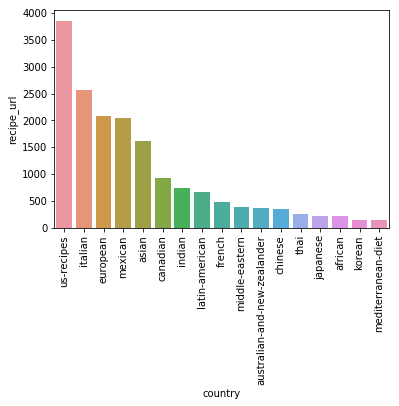

In [78]:
country_agg = url_df.pivot_table(index='country',values='recipe_url',aggfunc=len)
country_agg = country_agg.sort_values('recipe_url',ascending=False)
country_agg['country'] = country_agg.index
g = sns.barplot(x=country_agg['country'],y=country_agg['recipe_url'])
g = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [90]:
country_agg

,recipe_url,country
country,,
us-recipes,3852,us-recipes
italian,2571,italian
european,2086,european
mexican,2044,mexican
asian,1620,asian
canadian,934,canadian
indian,739,indian
latin-american,667,latin-american
french,475,french


## Scrape All Recipe Pages in World Cuisine

In addition to the recipe page listed in the above URLs, we also scrape the nutritional fact pages listed as sub-page `/fullrecipenutrition`.

In [85]:
# url_df = pd.read_csv(f'{DATA_PATH}url_df.csv')
# recipe_urls = list(url_df['recipe_url'])
# soups = []
# soup_nutris = []
# start_time = datetime.now()

# for i in range(len(recipe_urls)):
#     soup = get_soup(recipe_urls[i])
#     soups.append(soup)
    
#     nutri_url = f'{recipe_urls[i]}fullrecipenutrition'
#     soup_nutri = get_soup(nutri_url)
#     soup_nutris.append(soup_nutri)
    
#     if i % 100 == 0:
#         print(datetime.now()-start_time)
#         np.save(f'{RAW_PATH}soups.npy',[str(s) for s in soups])
#         np.save(f'{RAW_PATH}soup_nutris.npy',[str(s) for s in soup_nutris])

# np.save(f'{RAW_PATH}soups.npy',[str(s) for s in soups])
# np.save(f'{RAW_PATH}soup_nutris.npy',[str(s) for s in soup_nutris])

## Parse All Recipe Pages Scraped 

In [14]:
nutri_names = np.load(f'{RAW_PATH}nutri_names.npy')
soups = np.load(f'{RAW_PATH}soups.npy',mmap_mode='r')
soup_nutris = np.load(f'{RAW_PATH}soup_nutris.npy',mmap_mode='r')
len(soups),len(soup_nutris)

(2001, 2001)

In [15]:
ents=[]
start_time = datetime.now()
for i in range(len(soups)):
    if i % 100 ==0: print(f'{i} {datetime.now()-start_time}')
    soup = BeautifulSoup(soups[i],'html.parser')
    #if there's no recipe page at all
    try:
        recipe_url = soup.find('link', id='canonicalUrl').get('href')
    except:
        continue
    recipe_name = soup.find('h1',class_='recipe-summary__h1').get_text()
    titles = [' '.join(i.get_text().split()) for i in soup.find_all('span',class_='toggle-similar__title')]
    titles = '|'.join(titles)
    ratings = float(soup.find('div',class_='rating-stars').get('data-ratingstars'))
    nb_reviews = int(soup.find('span',class_='review-count').get_text().split(' ')[0])
    desc = ' '.join(soup.find('div', class_='submitter__description').get_text().split())
    ingre_names = soup.find_all('li',class_='checkList__line')
    ingre_names = '|'.join([re.sub('[^a-zA-Z0-9 ]','',i.get_text()) for i in ingre_names][:-3])
    ingre_ids = soup.find_all('span', class_='recipe-ingred_txt added')
    ingre_ids = '|'.join([i.get('data-id') for i in ingre_ids])
    all_times = soup.find('ul',class_='prepTime').find_all('time')
    ready_time = all_times[-1].get_text() if len(all_times)>0 else None
    directions = soup.find_all('li',class_='step')
    directions = '|'.join([' '.join(i.get_text().split()) for i in directions][:-1])

    soup_nutri = BeautifulSoup(soup_nutris[i],'html.parser')
    #if there's no nutrition page
    try:
        nutri_top = soup_nutri.find('div',class_='nutrition-top light-underline').get_text()[12:].split('\n')[:-1]
        nb_servings = int(nutri_top[0].split(': ')[1])
        nb_calories = int(nutri_top[2].split(': ')[1])
        nutri_names = soup_nutri.find_all('span',class_='nutrient-name')
        nutri_names = [re.sub(' ','_',i.get_text().split(': ')[0].lower()) for i in nutri_names]
        nutri_values = soup_nutri.find_all('span',class_='nutrient-value')
        nutri_values = [float(re.sub('[^0-9 ]','',i.get_text())) for i in nutri_values]
    except:
        nb_servings = None
        nb_calories = None
        nutri_names = np.load(f'{RAW_PATH}nutri_names.npy')
        nutri_values = [None for i in range(18)]

    ent = {'recipe_name':recipe_name, 'titles':titles, 'ratings':ratings, 'nb_reviews':nb_reviews,
          'desc':desc, 'ingre_names':ingre_names,'ingre_ids':ingre_ids,
          'ready_time':ready_time,
          'directions':directions,'nb_servings':nb_servings,'nb_calories':nb_calories}
    for j in range(len(nutri_names)): ent[nutri_names[j]] = nutri_values[j] 
    ents.append(ent)

df = pd.DataFrame(ents)
food_df = df[list(ent.keys())]
food_df.to_csv(f'{DATA_PATH}food_df.csv',index=False)

0 0:00:00.000678
100 0:00:18.237355
200 0:00:36.425587
300 0:00:54.787349
400 0:01:13.039826
500 0:01:31.171980
600 0:01:49.273215
700 0:02:08.324129
800 0:02:26.890283
900 0:02:45.427840
1000 0:03:04.679360
1100 0:03:23.347721
1200 0:03:41.861001
1300 0:04:00.060413
1400 0:04:18.419189
1500 0:04:37.006473
1600 0:04:55.513741
1700 0:05:14.075888
1800 0:05:32.890859
1900 0:05:51.472012
2000 0:06:09.789378
